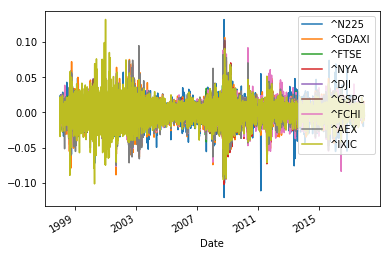

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 27)                0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 27)                108       
_________________________________________________________________
dropout_13 (Dropout)         (None, 27)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 56        
_________________________________________________________________
activation_13 (Activation)   (None, 2)                 0         
Total params: 164
Trainable params: 110
Non-trainable params: 54
_________________________________________________________________

――――― testdata : 2515 - 3017 ――――――――――


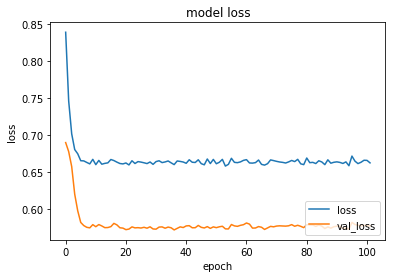

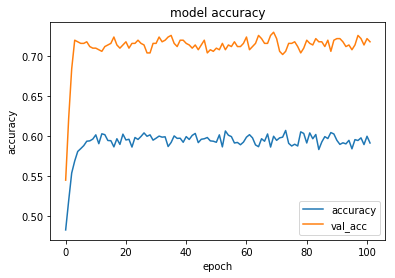

Individual accuracy : [0.6692913385826772, 0.79116465863453811]
accuracy : 0.729622266402


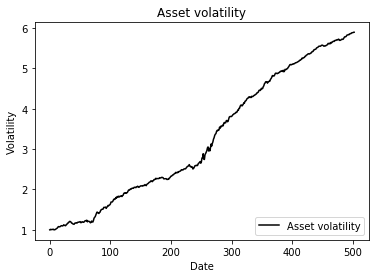

Final_Answer : [ 0.52937692  0.47062314]
accuracy : 0.7290836653386454
Final_Asset : 5.89739707904

――――― testdata : 3018 - 3520 ――――――――――


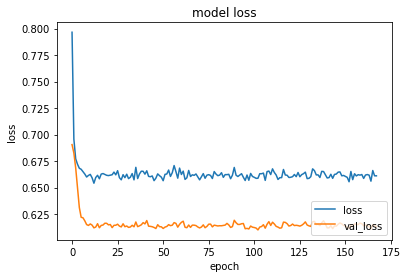

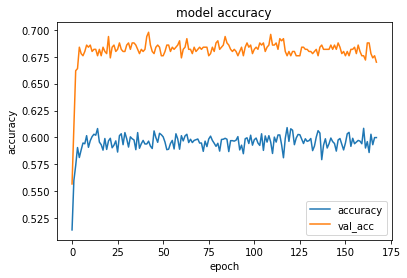

Individual accuracy : [0.63157894736842102, 0.76171875]
accuracy : 0.697813121272


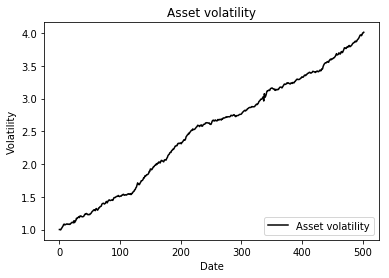

Final_Answer : [ 0.60203987  0.39796016]
accuracy : 0.6972111553784861
Final_Asset : 4.01500995743

――――― testdata : 3521 - 4023 ――――――――――


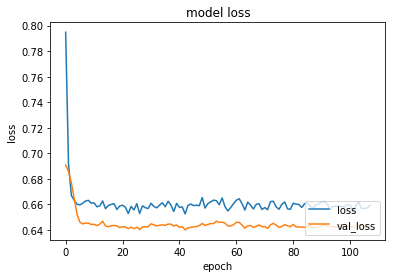

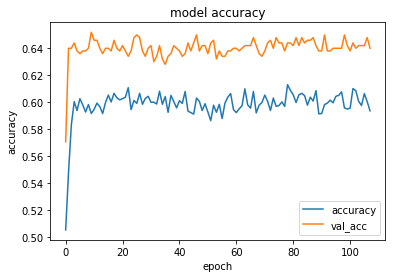

Individual accuracy : [0.57203389830508478, 0.72284644194756553]
accuracy : 0.652087475149


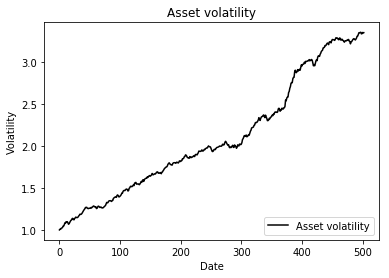

Final_Answer : [ 0.46157342  0.53842658]
accuracy : 0.651394422310757
Final_Asset : 3.35629532606

――――― testdata : 4024 - 4526 ――――――――――


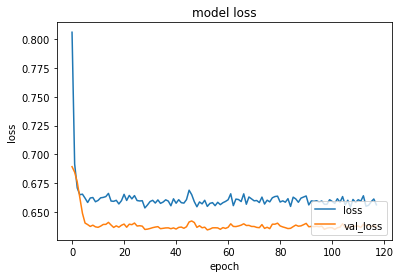

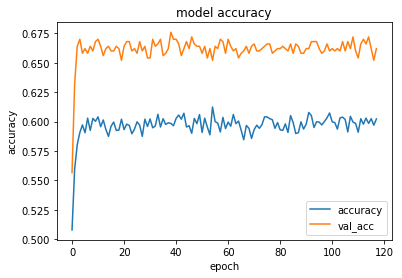

Individual accuracy : [0.63111111111111107, 0.71223021582733814]
accuracy : 0.675944333996


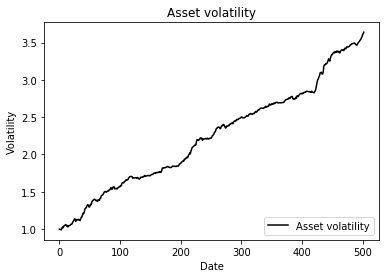

Final_Answer : [ 0.64608765  0.35391232]
accuracy : 0.6752988047808764
Final_Asset : 3.63784556334

――――― testdata : 4527 - 5030 ――――――――――


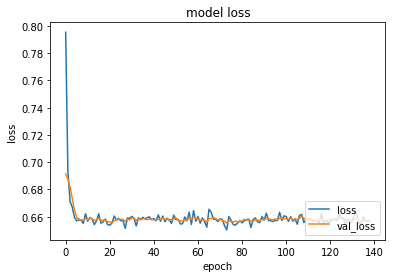

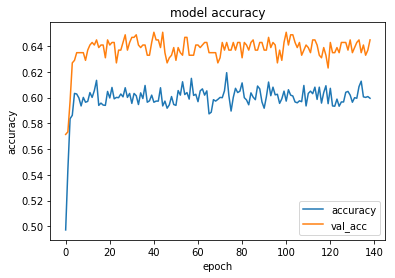

Individual accuracy : [0.57983193277310929, 0.7142857142857143]
accuracy : 0.650793650794


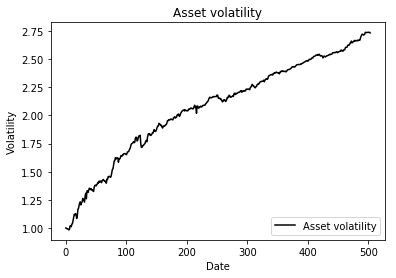

Final_Answer : [ 0.49499309  0.50500691]
accuracy : 0.651394422310757
Final_Asset : 2.73306051179
elapsed_time : 102.16534399986267 [sec]


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from keras_model import Model

INDEIES = ['^N225',
           #'^AORD',
           #'^HSI',
           '^GDAXI',
           '^FTSE',
           '^NYA',
           '^DJI',
           '^GSPC',
           '^FCHI',
           '^AEX',
           '^IXIC',
          ]
ANSWER = INDEIES[0]

def getClosing():
    closing = pd.DataFrame()
    for index in INDEIES:
        # na_valuesは文字列"null"のとき空として扱う
        df = pd.read_csv("../data/input5/" + index + ".csv", na_values=["null"])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date")
        closing[index] = np.log(df["Close"] / df["Close"].shift())
        if index is ANSWER:
            #closing[index] = np.log(df["Close"] / df["Open"])
            #closing[index] = np.log(df["Open"] / df["Open"].shift())
            #closing[index] = np.log(df["Close"] / df["Close"].shift())
            #closing[index] = np.log(df["Open"] / df["Close"].shift())
            closing["LH"] = (df["Close"].shift()-df["Low"])*(df["High"]-df["Close"].shift())
    # 空の部分は古いので埋める
    closing = closing.fillna(method="ffill")
    LH = np.array(closing["LH"])
    del closing["LH"]
    #for index in INDEIES:
        #closing[index] = np.log((closing[index]+1e-8) / (closing[index].shift()+1e-8))
        #closing[index] = ((closing[index]+1e-8)-(closing[index].shift()+1e-8)) / (closing[index].shift()+1e-8)
    #グラフ表示
    closing.plot()
    plt.show()
    closing["negative"] = 0
    # closing[ANSWER] < 0 の行のnegativeに 1
    closing.loc[closing[ANSWER] < 0, "negative"] = 1
    closing["positive"] = 0
    # closing[ANSWER] >= 0 の行のpositiveに 1
    closing.loc[closing[ANSWER] >= 0, "positive"] = 1
    return closing, LH

def getTraningData():
    closing, LH = getClosing()
    # 1~3日前のデータを予測に使う
    days_before = range(1,4)
    answers = pd.DataFrame(columns = ["negative", "positive"])
    columns = []
    for index in INDEIES:
        columns += [index + "_" + str(before) for before in days_before]
    features = pd.DataFrame(columns = columns)
    for i in range(max(days_before)+11, len(closing)):
        # 予測の部分は当日のデータ
        answers = answers.append({
            "negative" : closing["negative"].iloc[i],
            "positive" : closing["positive"].iloc[i]}, ignore_index=True)
        data={}
        # ほかの指標は１個前のデータ
        for index in INDEIES:
            for before in days_before :
                data[index + "_" + str(before)] = closing[index].iloc[i - before]
        features = features.append(data, ignore_index=True)
    for i in days_before :
        drop_col = ANSWER+"_"+str(i)
        #del features[drop_col] # 予測するデータの過去データを入れないとき
    LH = LH[max(days_before)+11: len(closing)]
    # 予測する元のデータ , 予測するべきデータ
    return features, answers, LH

if __name__ == "__main__":
    start = time.time()
    features, answers, LH = getTraningData()
    popo = 10
    layers = []
    model = Model(features,answers,layers)
    for test in range(5,popo):
        model.initial(test/popo,(test+1)/popo)
        model.train(1000,32,64)
        model.test()
        model.value(ANSWER,1)
    print("elapsed_time :", time.time()-start, "[sec]")